<a href="https://colab.research.google.com/github/VictorFrancheto/Google_Stock_Prediction/blob/main/__google_stock_prediction__.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Stock Price Prediction using PyTorch

This project aims to predict the future performance of Google stock through time series analysis. Time series are datasets organized in chronological order, and their analysis enables the extraction of valuable insights into stock behavior. In this notebook, we will use tools like Seaborn and Matplotlib to explore and visualize various aspects of Google stock's historical data. Additionally, we will analyze methods to assess the risks associated with the asset based on its past performance.

#### Dataset Overview

The selected dataset spans from **June 14, 2016**, to **June 11, 2021**. Each row represents daily stock market data for Google during this period. Below is a brief description of the variables present in the dataset:

#### Dataset Attributes
---

- **symbol**: The company's name (in this case, Google).
- **date**: The specific date of the record.
- **close**: The closing price of the stock.
- **high**: The highest price of the stock on that day.
- **low**: The lowest price of the stock on that day.
- **open**: The opening price of the stock on the given date.
- **volume**: The trading volume (number of shares traded) on the given date.
- **adjClose**: The adjusted closing price, accounting for corporate actions such as splits or dividends.
- **adjHigh**: The adjusted highest price reached by the stock on the given date.
- **adjLow**: The adjusted lowest price reached by the stock on the given date.
- **adjOpen**: The adjusted opening price of the stock on the given date.
- **adjVolume**: The adjusted trading volume (number of shares traded) on the given date.
- **divCash**: The amount of cash dividends paid on the given date (if any).
- **splitFactor**: The stock split factor applied on the given date (if any).
----

### Objective

The primary goal of this analysis is to extract insights and forecast the future performance of Google's stock using historical data from the dataset. This will involve exploring key patterns, assessing associated risks, and applying predictive models. For this specific case, we will use PyTorch.


# Exploratory Data Analysis (EDA)

### Importing Libaries

In [1]:
# Data manipulation and preprocessing
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Plotting
import matplotlib.pyplot as plt

# Technical analysis
from ta.momentum import RSIIndicator

# PyTorch for neural networks
import torch
import torch.nn as nn



#### Defining functions that will be used

In [2]:
def check_null_values(df):
    """
    Function to check the number of null values in each column of a DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame to analyze.

    Returns:
        pd.DataFrame: A DataFrame containing columns, the number of null values, and the percentage of nulls.
    """
    null_info = pd.DataFrame({
        'Column': df.columns,
        'Null Count': df.isnull().sum(),
        'Null Percentage': (df.isnull().sum() / len(df)) * 100
    }).reset_index(drop=True)
    return null_info.sort_values(by='Null Count', ascending=False)

def calculate_mape(real, predicted):
    return (abs((real - predicted) / real).mean()) * 100


#### Creating data frames with the necessary information

The dataset used in this analysis can be easily found on Kaggle at the following link: [Google Stock Prediction](https://www.kaggle.com/code/amirhosseinmirzaie/google-stock-prediction-lstm/input) or downloaded directly from the files provided in this project.


In [3]:
df = pd.read_csv('GOOG.csv')
df.tail()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1253,GOOG,2021-06-07 00:00:00+00:00,2466.09,2468.000,2441.0725,2451.32,1192453,2466.09,2468.000,2441.0725,2451.32,1192453,0.0,1.0
1254,GOOG,2021-06-08 00:00:00+00:00,2482.85,2494.495,2468.2400,2479.90,1253253,2482.85,2494.495,2468.2400,2479.90,1253253,0.0,1.0
1255,GOOG,2021-06-09 00:00:00+00:00,2491.40,2505.000,2487.3300,2499.50,1006337,2491.40,2505.000,2487.3300,2499.50,1006337,0.0,1.0
1256,GOOG,2021-06-10 00:00:00+00:00,2521.60,2523.260,2494.0000,2494.01,1561733,2521.60,2523.260,2494.0000,2494.01,1561733,0.0,1.0
1257,GOOG,2021-06-11 00:00:00+00:00,2513.93,2526.990,2498.2900,2524.92,1262309,2513.93,2526.990,2498.2900,2524.92,1262309,0.0,1.0


### Checking the percentage of null values

In [4]:
check_null_values(df)

,Column,Null Count,Null Percentage
0,symbol,0,0.0
1,date,0,0.0
2,close,0,0.0
3,high,0,0.0
4,low,0,0.0
5,open,0,0.0
6,volume,0,0.0
7,adjClose,0,0.0
8,adjHigh,0,0.0
9,adjLow,0,0.0


Note that the `symbol` column contains the same value in all rows. Therefore, We will remove it.

In [5]:
df.drop(['symbol'], axis=1, inplace=True)

In the next step, we will adjust the `date` column.

In [6]:
df['date'] = pd.to_datetime(df['date']).dt.date

Now, let's analyze the graphical behavior of the columns `close`, `high`, `low`, `open`, and `volume` grouped by month and year in relation to the `price` column.

<ipython-input-7-74470653c994>:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = df[['close', 'high', 'low', 'open', 'volume']].resample('M').mean()
<ipython-input-7-74470653c994>:11: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_avg = df[['close', 'high', 'low', 'open', 'volume']].resample('Y').mean()


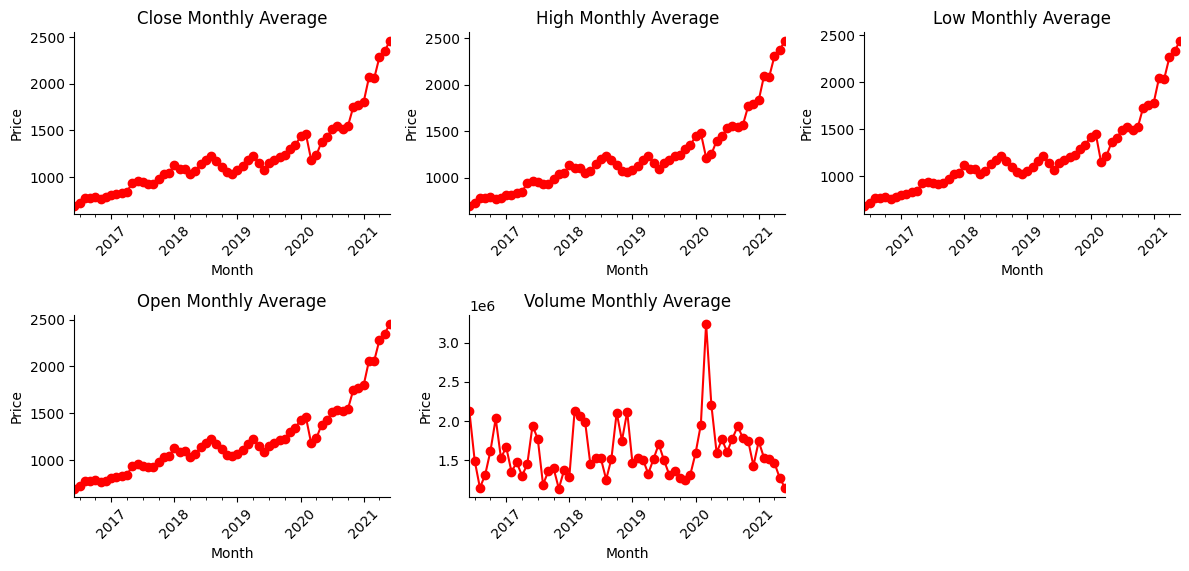

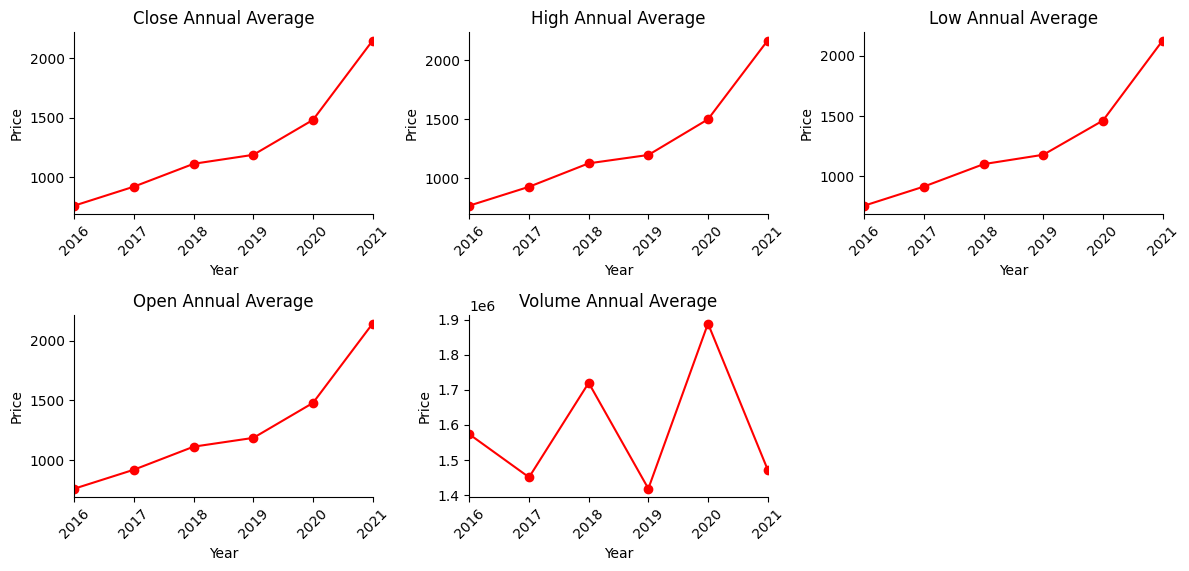

In [7]:
# Convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Set the 'date' column as the index
df.set_index('date', inplace=True)

# Calculate monthly averages
monthly_avg = df[['close', 'high', 'low', 'open', 'volume']].resample('M').mean()

# Calculate annual averages
annual_avg = df[['close', 'high', 'low', 'open', 'volume']].resample('Y').mean()

# Plot configurations
metrics = ['close', 'high', 'low', 'open', 'volume']  # Columns to be plotted
n_rows, n_cols = 3, 3  # 2 rows and 3 columns per figure
fig_size = (12, 8)  # Smaller figure size
plots_per_figure = n_rows * n_cols
plot_counter = 0

# Function to create subplots
def plot_metrics(data, title_suffix, xlabel):
    global plot_counter  # Use the global plot counter
    for metric in metrics:
        if plot_counter % plots_per_figure == 0:
            if plot_counter > 0:
                plt.tight_layout()
                plt.show()
            fig = plt.figure(figsize=fig_size)  # Create a new figure
        plt.subplot(n_rows, n_cols, (plot_counter % plots_per_figure) + 1)
        data[metric].plot(marker='o', color='red')  # Set line color to red
        plt.title(f'{metric.capitalize()} {title_suffix}')
        plt.xlabel(xlabel)
        plt.ylabel('Price')
        plt.xticks(rotation=45)
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.gca().set_facecolor('white')  # Set background to white
        plot_counter += 1
    plt.tight_layout()
    plt.show()

# Plot monthly averages
plot_counter = 0  # Reset plot counter
plot_metrics(monthly_avg, 'Monthly Average', 'Month')

# Plot annual averages
plot_counter = 0  # Reset plot counter
plot_metrics(annual_avg, 'Annual Average', 'Year')


Similarly to the previous case, but now we will group by month regardless of the year.

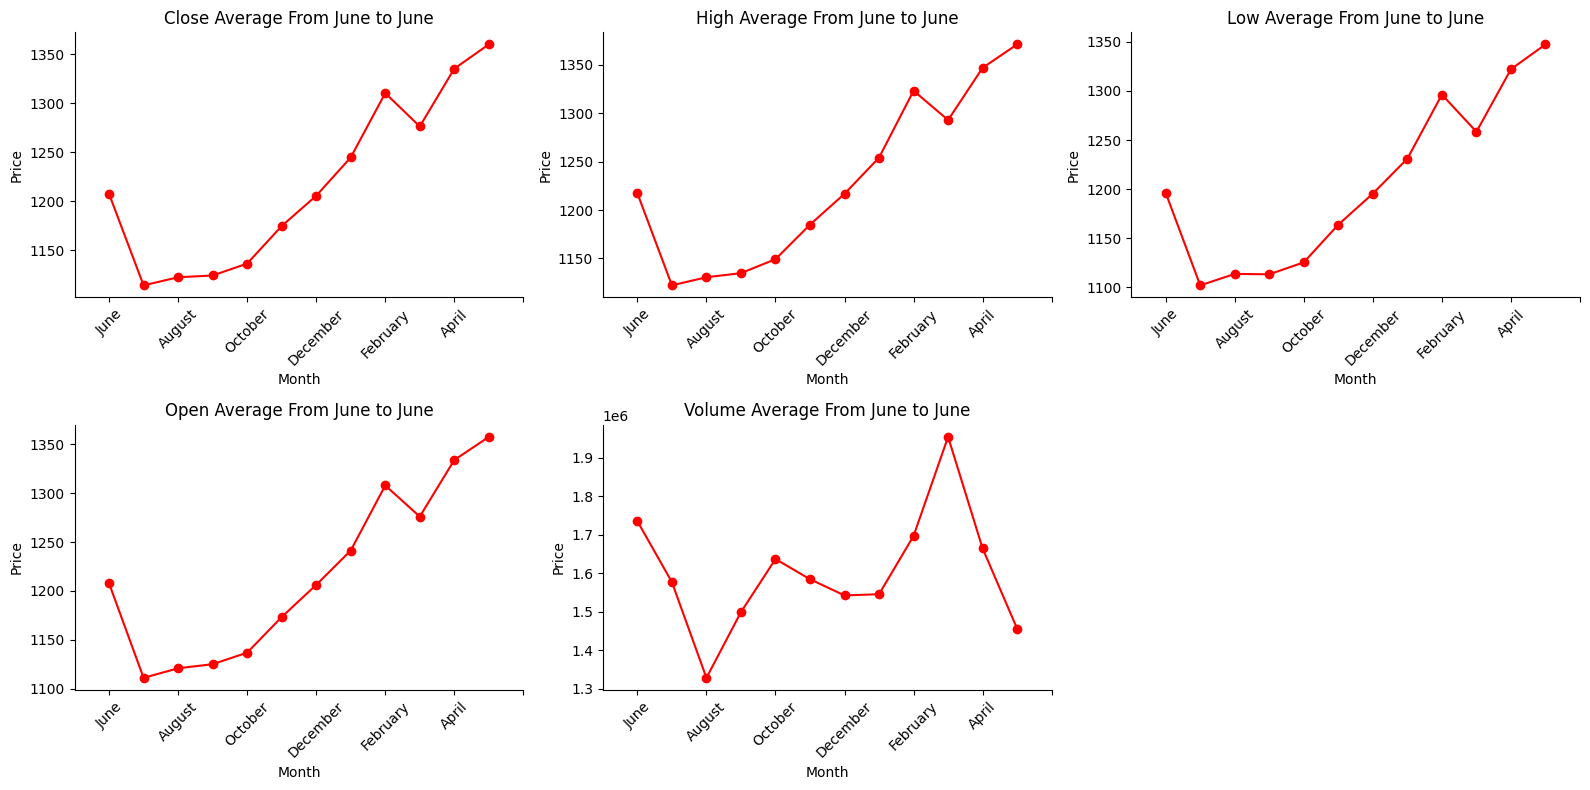

In [8]:
monthly_avg = df[['close', 'high', 'low', 'open', 'volume']].groupby(df.index.month_name()).mean()

# Ensure the months are ordered from June to June
month_order = ['June', 'July', 'August', 'September', 'October', 'November', 'December',
               'January', 'February', 'March', 'April', 'May']
monthly_avg = monthly_avg.loc[month_order]

# Plot configurations
metrics = ['close', 'high', 'low', 'open', 'volume']  # Columns to be plotted
n_rows, n_cols = 2, 3  # 2 rows and 3 columns per figure
fig_size = (16, 8)  # Adjusted figure size
plots_per_figure = n_rows * n_cols
plot_counter = 0

# Function to create subplots
def plot_metrics(data, title_suffix, xlabel):
    global plot_counter  # Use the global plot counter
    for metric in metrics:
        if plot_counter % plots_per_figure == 0:
            if plot_counter > 0:
                plt.tight_layout()
                plt.show()
            fig = plt.figure(figsize=fig_size)  # Create a new figure
        plt.subplot(n_rows, n_cols, (plot_counter % plots_per_figure) + 1)
        data[metric].plot(marker='o', color='red')  # Set line color to red
        plt.title(f'{metric.capitalize()} {title_suffix}')
        plt.xlabel(xlabel)
        plt.ylabel('Price')
        plt.xticks(rotation=45, fontsize=10)
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.gca().set_facecolor('white')  # Set background to white
        plt.gca().set_xlim([-1, 12])  # Extend the X-axis range for better visibility
        plot_counter += 1
    plt.tight_layout()
    plt.show()

# Plot monthly averages (aggregated across years)
plot_counter = 0  # Reset plot counter
plot_metrics(monthly_avg, 'Average From June to June', 'Month')


Let's check if, on average, it is possible to identify peak days or not related to the performance of Close, High, Low, Open, and Volume in relation to price.

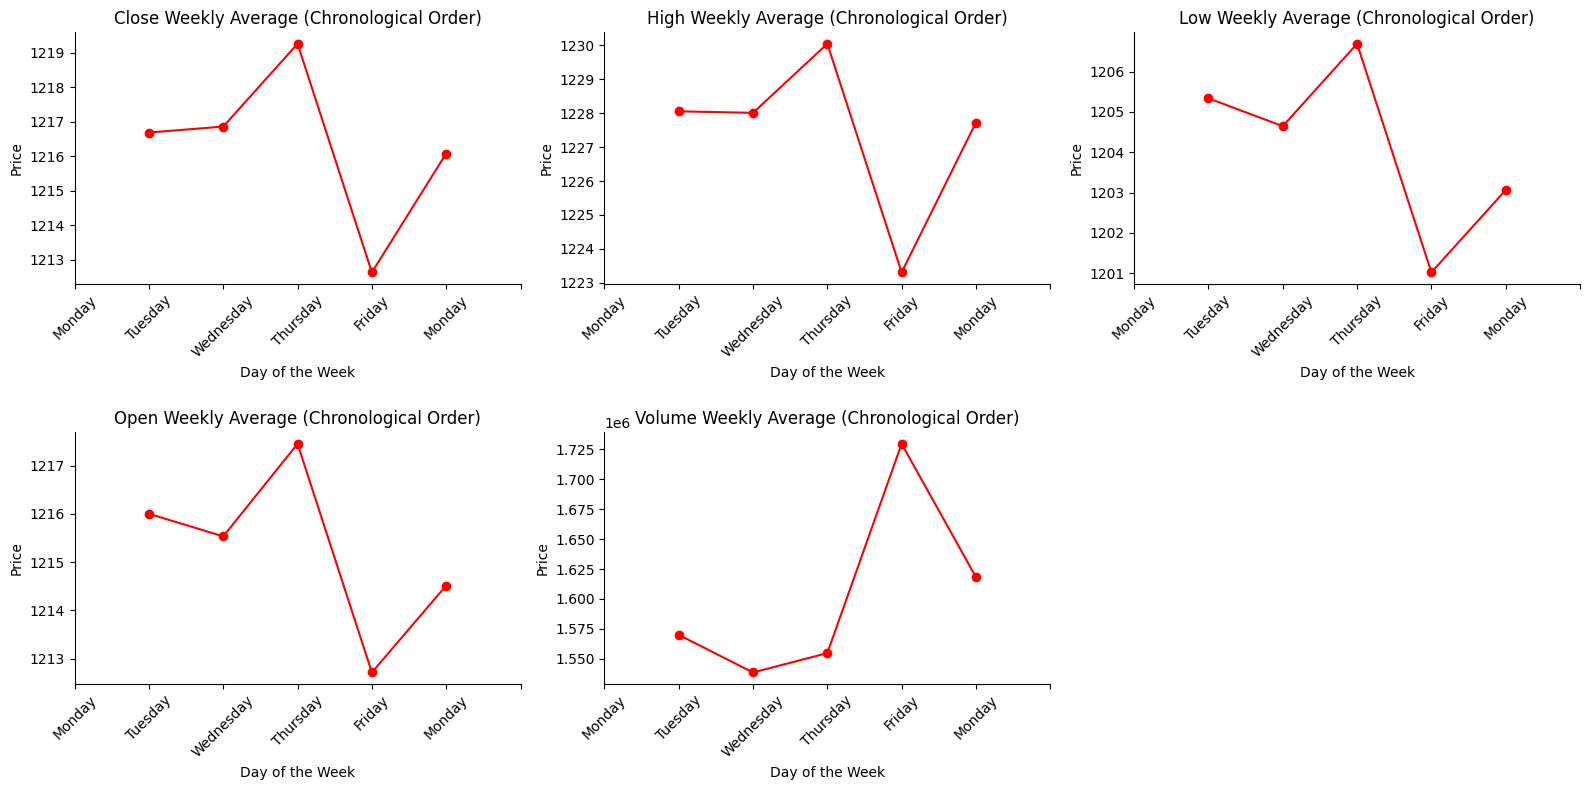

In [9]:
# Group by day of the week to calculate averages
weekly_avg = df[['close', 'high', 'low', 'open', 'volume']].groupby(df.index.day_name()).mean()

# Preserve the chronological order of days in the dataset
day_order = pd.Categorical(df.index.day_name(), categories=df.index.day_name().unique(), ordered=True)
weekly_avg.index = pd.Categorical(weekly_avg.index, categories=day_order.categories, ordered=True)

# Sort by the chronological order
weekly_avg = weekly_avg.sort_index()

# Plot configurations
metrics = ['close', 'high', 'low', 'open', 'volume']  # Columns to be plotted
n_rows, n_cols = 2, 3  # 2 rows and 3 columns per figure
fig_size = (16, 8)  # Adjusted figure size
plots_per_figure = n_rows * n_cols
plot_counter = 0

# Function to create subplots
def plot_metrics(data, title_suffix, xlabel):
    global plot_counter  # Use the global plot counter
    for metric in metrics:
        if plot_counter % plots_per_figure == 0:
            if plot_counter > 0:
                plt.tight_layout()
                plt.show()
            fig = plt.figure(figsize=fig_size)  # Create a new figure
        plt.subplot(n_rows, n_cols, (plot_counter % plots_per_figure) + 1)
        data[metric].plot(marker='o', color='red')  # Set line color to red
        plt.title(f'{metric.capitalize()} {title_suffix}')
        plt.xlabel(xlabel)
        plt.ylabel('Price')
        plt.xticks(rotation=45, fontsize=10)
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.gca().set_facecolor('white')  # Set background to white
        plt.gca().set_xlim([-1, len(data.index)])  # Extend the X-axis range for better visibility
        plot_counter += 1
    plt.tight_layout()
    plt.show()

# Plot weekly averages (in the order of the dataset)
plot_counter = 0  # Reset plot counter
plot_metrics(weekly_avg, 'Weekly Average (Chronological Order)', 'Day of the Week')


#### Observations:
#### Close, High, Low, and Open:
- Thursdays show the highest values for Close, High, Low, and Open compared to other days of the week. On average, stock prices tend to peak on Thursdays relative to other days.
- In contrast, the lowest values for Close, High, Low, and Open are observed on Fridays, indicating that stock prices are relatively lower on the last day of the week.

#### Volume:
- Thursdays have the lowest average trading volume compared to other days of the week. This suggests that there is generally less trading activity (fewer shares being bought or sold) on Thursdays.
- Other days of the week exhibit higher average trading volumes, reflecting increased trading activity and greater liquidity.


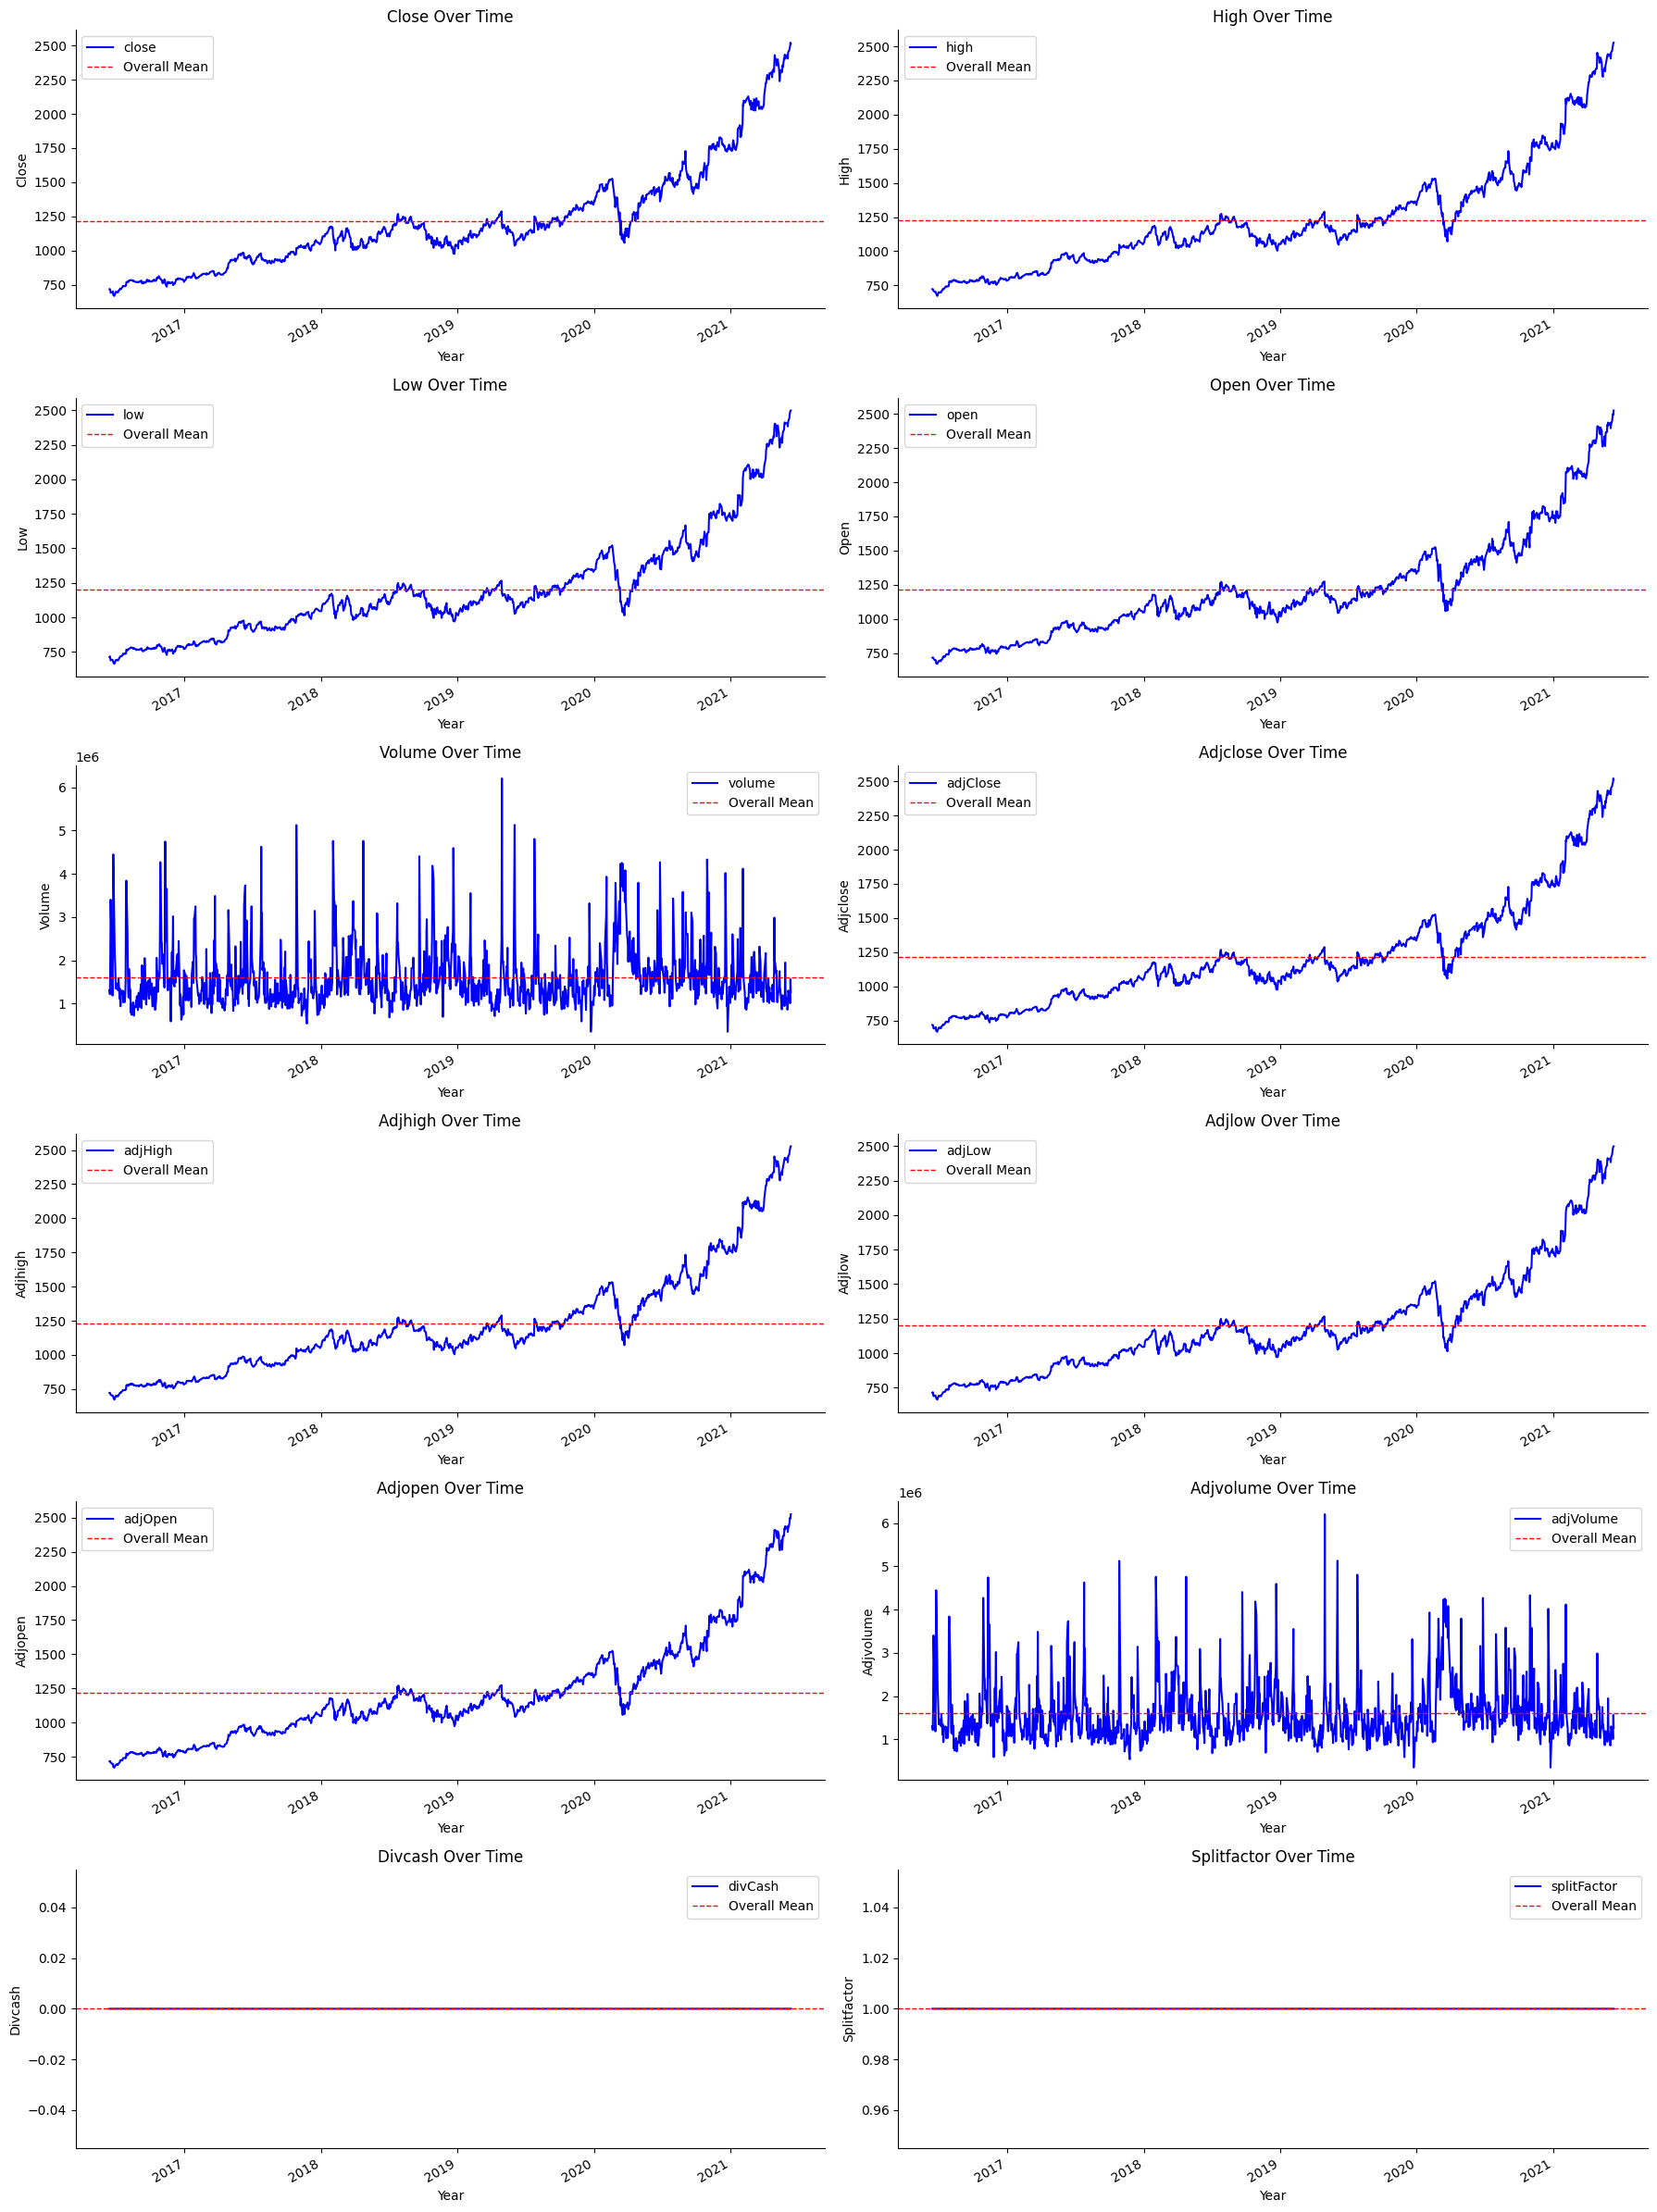

In [10]:
# List of variables to plot
variables = ['close', 'high', 'low', 'open', 'volume',
             'adjClose', 'adjHigh', 'adjLow', 'adjOpen', 'adjVolume',
             'divCash', 'splitFactor']

# Layout settings
n_rows, n_cols = 6, 2  # 6 rows and 2 columns
fig_size = (18, 24)    # Figure size
plot_counter = 0

# Create the main figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=fig_size)
axes = axes.flatten()  # Flatten the list of subplots into a single array

for i, var in enumerate(variables):
    if var in df.columns:
        ax = axes[plot_counter]
        # Plot the data directly
        df[var].plot(ax=ax, color='blue', label=f'{var}')

        # Add a line indicating the overall mean
        overall_mean = df[var].mean()
        ax.axhline(overall_mean, color='red', linestyle='--', linewidth=1, label='Overall Mean')

        # Chart configurations
        ax.set_title(f'{var.capitalize()} Over Time')
        ax.set_xlabel('Year')
        ax.set_ylabel(var.capitalize())
        ax.legend()

        # Remove background lines but keep the axes
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(False)  # Disable the grid

        plot_counter += 1

# Remove empty subplots if any
for i in range(plot_counter, len(axes)):
    fig.delaxes(axes[i])

# Adjust layout
plt.tight_layout()
plt.show()


Let’s analyze how the moving average of the `close` column behaves in comparison to the original data.

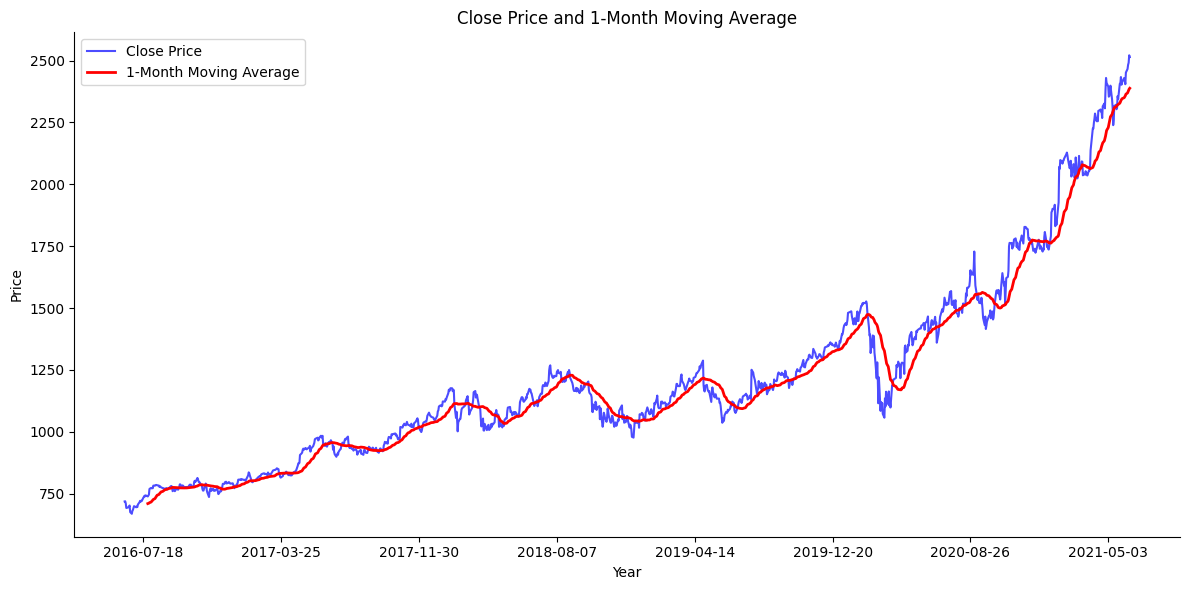

In [11]:

# Calculate the 60-day moving average
df['2_months_moving_avg'] = df['close'].rolling(window=30).mean()

# Create the plot
plt.figure(figsize=(12, 6))

# Plot the closing price series
plt.plot(df.index, df['close'], label='Close Price', alpha=0.7, color='blue')

# Plot the 60-day moving average
plt.plot(df.index, df['2_months_moving_avg'], label='1-Month Moving Average', color='red', linewidth=2)

# Configure the X-axis and title
plt.title('Close Price and 1-Month Moving Average')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend()

# Remove grid lines but keep the X and Y axes
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(True)
plt.gca().spines['left'].set_visible(True)

# Format the X-axis to show only years
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))  # Show years

# Display the plot
plt.tight_layout()
plt.show()


The moving average is a simple tool to identify price trends and potential entry or exit points in assets.

- **Uptrend**: When the price is above the moving average, it indicates market strength or an upward movement, often interpreted as a signal to buy or maintain a long position.

- **Downtrend**: When the price is below the moving average, it suggests weakness or a downward movement, commonly seen as a signal to sell or adopt a defensive stance.



### RSI Overview

The Relative Strength Index (RSI) is a widely used technical indicator in financial market analysis that measures the strength and speed of price changes in an asset. It helps identify overbought (overvalued) or oversold (undervalued) conditions in the market, allowing traders and investors to make informed decisions about buying or selling an asset.

The RSI is expressed as a value between 0 and 100. Typically, a value above 70 indicates that the asset may be overbought, potentially signaling an upcoming correction or decline. A value below 30 suggests that the asset may be oversold, indicating a potential recovery.

### RSI Calculation

The RSI calculation involves the following steps:

1. **Calculate Average Gains and Losses**:
   - For a standard period of 14 days:
     - **Average Gain**: The average of all positive price changes during the period.
     - **Average Loss**: The average of all negative price changes during the period.

2. **Calculate Relative Strength (RS)**:
   $$
   RS = \frac{\text{Average Gain}}{\text{Average Loss}}
   $$

3. **Apply the RSI Formula**:
   $$
   RSI = 100 - \left( \frac{100}{1 + RS} \right)
   $$

### RSI Usage in Daily Trading

Traders and investors use the RSI to identify trends and optimal moments to enter or exit the market. Its main applications include:

1. **Overbought and Oversold Conditions**:
   - **RSI > 70**: Indicates the asset may be overbought, suggesting that the price may have risen too quickly and a correction or reversal could occur.
   - **RSI < 30**: Indicates the asset may be oversold, suggesting that the price may have fallen too quickly and a recovery may follow.

2. **Trend Confirmation**:
   - The RSI can be used to confirm the direction of a trend. For example, in a strong uptrend, the RSI often remains above 50, while in a strong downtrend, it often stays below 50.

3. **Identifying Divergences**:
   - A divergence occurs when the price of an asset is rising, but the RSI is falling (or vice versa). This can indicate a potential trend reversal.

4. **Complementing Other Strategies**:
   - The RSI is rarely used in isolation. It is often combined with other indicators, such as moving averages or support and resistance levels, to enhance decision-making precision.


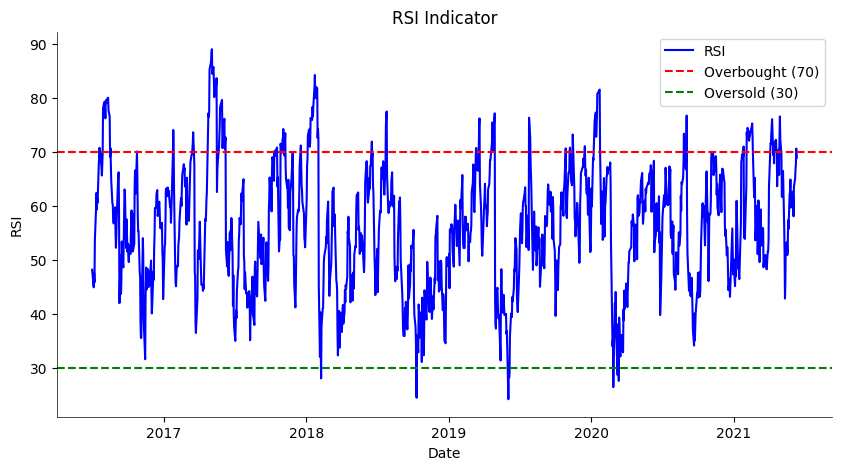

In [12]:
# Reset the index to use 'date' as a column
df.reset_index('date', inplace=True)

# Calculate the RSI using the 'ta' library
rsi = RSIIndicator(df['close']).rsi()

# Add the RSI values to the DataFrame (optional)
df['RSI'] = rsi

# Plot the RSI
plt.figure(figsize=(10, 5))
plt.plot(df['date'], rsi, color='blue', label='RSI')  # Plot the RSI line
plt.axhline(70, color='red', linestyle='--', label='Overbought (70)')  # Overbought threshold
plt.axhline(30, color='green', linestyle='--', label='Oversold (30)')  # Oversold threshold
plt.title('RSI Indicator')  # Chart title
plt.xlabel('Date')  # X-axis label
plt.ylabel('RSI')  # Y-axis label
plt.legend()  # Display the legend

# Adjust the style to remove background lines
ax = plt.gca()  # Get current axis
ax.spines['top'].set_visible(False)  # Remove the top line
ax.spines['right'].set_visible(False)  # Remove the right line
ax.spines['left'].set_linewidth(0.5)  # Set the thickness of the Y-axis line
ax.spines['bottom'].set_linewidth(0.5)  # Set the thickness of the X-axis line
plt.grid(False)  # Remove the grid from the plot

plt.show()


### Relative Strength Index (RSI): Overbought and Oversold

#### Overbought
The **highest values** of the Relative Strength Index (RSI) are typically associated with **overbought conditions**.

- When the RSI exceeds **70**, it indicates that the asset may be **overvalued** or **overbought**.  
- In such cases, there is a **higher probability** of a **price correction** or a **downward reversal** in the near future.  
- This suggests that buying pressure may have driven the price to **unsustainable levels**, making a **pullback** or **downward movement** more likely.

---

#### Oversold
The **lowest values** of the RSI are typically associated with **oversold conditions**.

- When the RSI falls below **30**, it indicates that the asset may be **undervalued** or **oversold**.  
- In such cases, there is a **higher probability** of a **price recovery** or an **upward reversal** in the near future.  
- This suggests that selling pressure may have pushed the price to **excessively low levels**, making a **rebound** or **upward movement** more likely.

### Modeling

In [13]:
X = df.copy()

X = X[['date', 'high','low','open','close']] # Extracting required columns
X.tail()

,date,high,low,open,close
1253,2021-06-07,2468.000,2441.0725,2451.32,2466.09
1254,2021-06-08,2494.495,2468.2400,2479.90,2482.85
1255,2021-06-09,2505.000,2487.3300,2499.50,2491.40
1256,2021-06-10,2523.260,2494.0000,2494.01,2521.60
1257,2021-06-11,2526.990,2498.2900,2524.92,2513.93


In this specific project, we aim to predict the closing price of a stock on a given day, represented by the variable `close`. It is worth noting that other variables, such as `low` and `high`, can also be predicted, but here we will focus exclusively on the `close` variable. Once we know the opening price of the stock, represented by the column `open`, we will be able to predict its closing value.

An interesting aspect of stock market dynamics is that if one can predict whether a stock will rise or fall and this information is disclosed in some way, the stock's price may rise or fall depending on the scenario, potentially undermining the performance of the created model.



In [14]:
# Data scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X[['close', 'open']])  # Normalize the 'close' and 'open' columns

# Preparing the data for the model
features = torch.tensor(X_scaled[:, 1:], dtype=torch.float32)  # 'open' as input
target = torch.tensor(X_scaled[:, 0], dtype=torch.float32).unsqueeze(1)  # 'close' as target

# Splitting the data into training and testing sets
train_size = int(0.9 * features.shape[0])
features_train, features_test = features[:train_size], features[train_size:]
target_train, target_test = target[:train_size], target[train_size:]
dates_test = X['date'][train_size:].values  # Dates corresponding to the test set

### Neural Network Architecture Definition

In [15]:
class ForecastNN(nn.Module):
    def __init__(self):
        super(ForecastNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(1, 64),  # One input: 'open'
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)  # One output: 'close'
        )

    def forward(self, x):
        return self.fc(x)

# Initializing the model
model = ForecastNN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Model training
epochs = 250
train_losses = []
test_losses = []

for epoch in range(epochs):
    # Training mode
    model.train()
    y_pred = model(features_train)
    loss = criterion(y_pred, target_train)
    train_losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Validation mode
    model.eval()
    with torch.no_grad():
        val_loss = criterion(model(features_test), target_test)
        test_losses.append(val_loss.item())

    if (epoch + 1) % 50 == 0:
        print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {val_loss.item():.4f}')

# Predicting values
model.eval()
with torch.no_grad():
    predicted = model(features_test).squeeze().numpy()

# Rescaling the predicted and real values
predicted_rescaled = scaler.inverse_transform(np.c_[predicted, np.zeros((len(predicted), 1))])[:, 0]
real_rescaled = scaler.inverse_transform(np.c_[target_test.squeeze().numpy(), np.zeros((len(target_test), 1))])[:, 0]

# Creating a DataFrame with the results
results = pd.DataFrame({
    'date': dates_test,                   # Dates from the test set
    'real': real_rescaled,                # Real 'close' values
    'predicted': predicted_rescaled       # Predicted 'close' values
})


Epoch 50/250, Train Loss: 0.0107, Test Loss: 0.1916
Epoch 100/250, Train Loss: 0.0036, Test Loss: 0.0671
Epoch 150/250, Train Loss: 0.0003, Test Loss: 0.0111
Epoch 200/250, Train Loss: 0.0001, Test Loss: 0.0036
Epoch 250/250, Train Loss: 0.0001, Test Loss: 0.0035


### Plotting the Comparison Between Real and Predicted Values

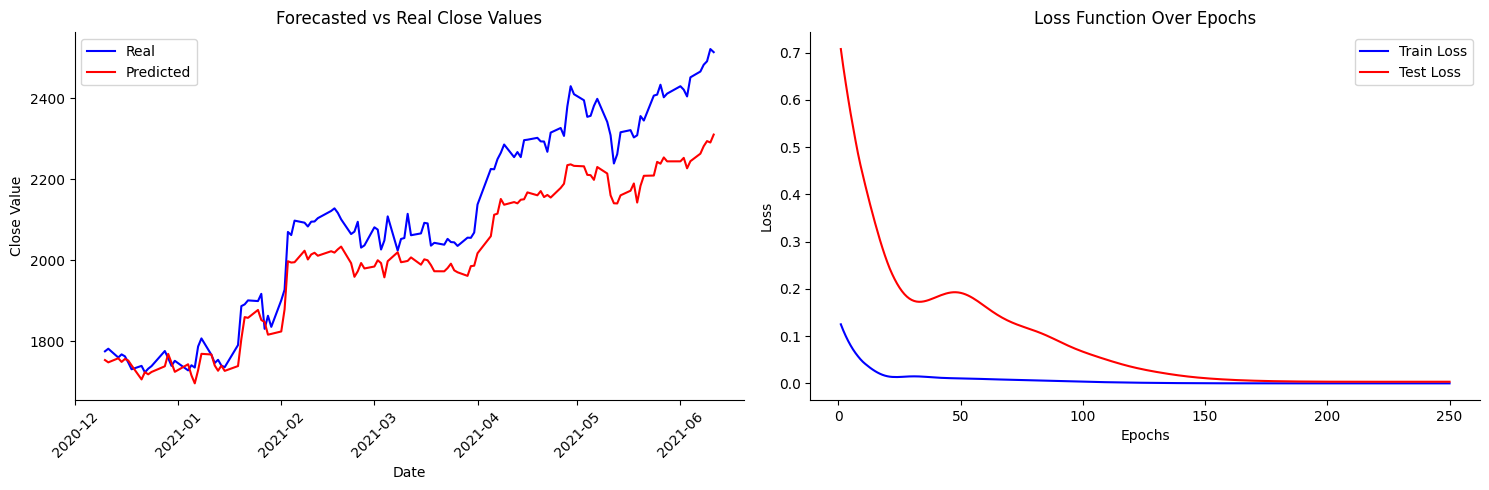

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))  # Create two side-by-side plots

# Plot 1: Real vs Predicted Close Values
ax[0].plot(results['date'], results['real'], label='Real', color='blue')
ax[0].plot(results['date'], results['predicted'], label='Predicted', color='red')
ax[0].set_title('Forecasted vs Real Close Values')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Close Value')
ax[0].legend()
ax[0].tick_params(axis='x', rotation=45)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].grid(False)

# Plot 2: Loss Function (Train vs Test)
ax[1].plot(range(1, epochs + 1), train_losses, label='Train Loss', color='blue')
ax[1].plot(range(1, epochs + 1), test_losses, label='Test Loss', color='red')  # Test in red
ax[1].set_title('Loss Function Over Epochs')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].grid(False)

plt.tight_layout()
plt.show()

### MAPE

In [17]:
if (results['real'] == 0).any():
    print("There are zero values in the 'real' column, which could cause division by zero.")
else:
    mape = calculate_mape(results['real'], results['predicted'])
    print(f"The MAPE (Mean Absolute Percentage Error) is: {mape:.2f}%")


The MAPE (Mean Absolute Percentage Error) is: 4.18%
